##CIFAR-10 dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

Training set shape: (50000, 32, 32, 3)
Testing set shape: (10000, 32, 32, 3)


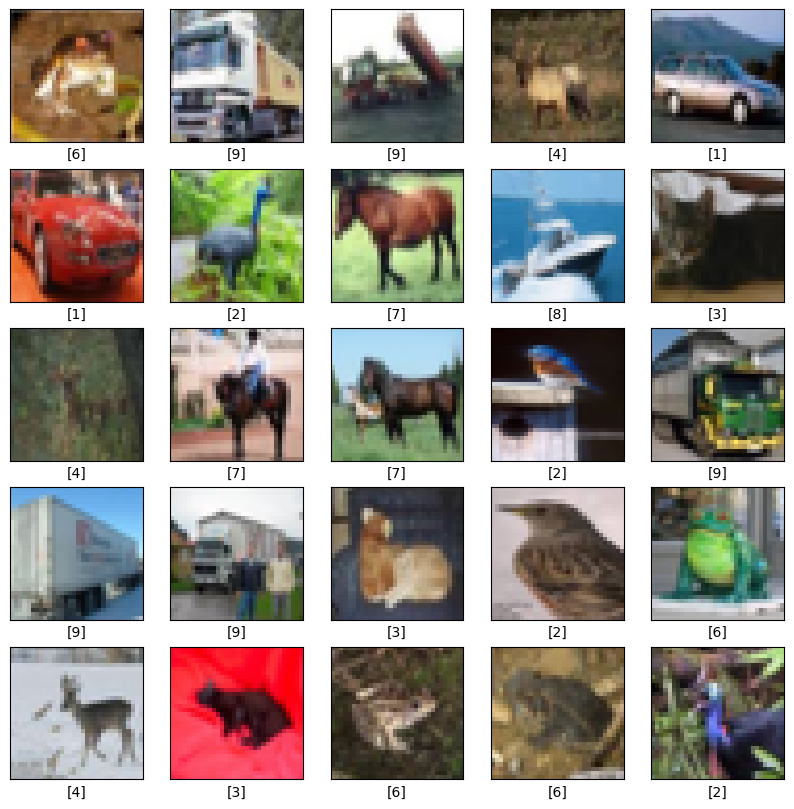

In [2]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values of the images to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Verify the dataset
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Optionally, display some images from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [3]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.num_hidden = 64  # Adjusted for CIFAR-10's complexity

        # Encoder
        self.encoder = tf.keras.Sequential([
            Flatten(input_shape=(32, 32, 3)),  # Adjusted for CIFAR-10
            Dense(512, activation='relu'),
            Dense(self.num_hidden, activation='relu')
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Dense(512, activation='relu'),
            Dense(32 * 32 * 3, activation='sigmoid'),  # Adjusted for CIFAR-10
            Reshape((32, 32, 3))  # Adjusted for CIFAR-10
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the Autoencoder
autoencoder = AutoEncoder()

# Summary of the model to visualize its architecture
autoencoder.build((None, 32, 32, 3))  # None is for batch size, which can be variable
autoencoder.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                1606208   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         1609216   
                                                                 
Total params: 3215424 (12.27 MB)
Trainable params: 3215424 (12.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# Define optimizer and loss function for the Autoencoder
optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

# Training loop for the Autoencoder
epochs = 5
batch_size = 32
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step in range(len(X_train) // batch_size):
        x_batch_train = X_train[step * batch_size : (step + 1) * batch_size]
        with tf.GradientTape() as tape:
            decoded = autoencoder(x_batch_train)
            loss = mse_loss_fn(x_batch_train, decoded)
        grads = tape.gradient(loss, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(grads, autoencoder.trainable_variables))

    print("Epoch %d: Loss value for training set: %.4f" % (epoch, float(loss)))


Start of epoch 0


Epoch 0: Loss value for training set: 0.0224

Start of epoch 1
Epoch 1: Loss value for training set: 0.0208

Start of epoch 2
Epoch 2: Loss value for training set: 0.0202

Start of epoch 3
Epoch 3: Loss value for training set: 0.0200

Start of epoch 4
Epoch 4: Loss value for training set: 0.0199



Start of epoch 0
Epoch 0: Loss value for training set: 151.0819

Start of epoch 1
Epoch 1: Loss value for training set: 149.8586

Start of epoch 2
Epoch 2: Loss value for training set: 148.9122

Start of epoch 3
Epoch 3: Loss value for training set: 148.7733

Start of epoch 4
Epoch 4: Loss value for training set: 148.5782


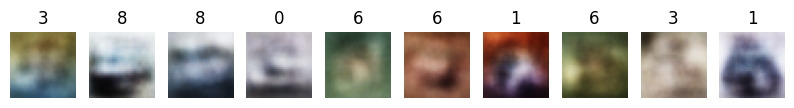

In [5]:
# Load and preprocess the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train.astype('float32') / 255.0, X_test.astype('float32') / 255.0

class VAE(tf.keras.Model):
    """Variational Autoencoder for CIFAR-10 dataset."""
    def __init__(self):
        super(VAE, self).__init__()
        self.num_hidden = 64  # Number of dimensions in the latent space

        # Encoder: Maps inputs to the latent space
        self.encoder = tf.keras.Sequential([
            Flatten(input_shape=(32, 32, 3)),
            Dense(512, activation='relu'),
            Dense(self.num_hidden * 2)  # Outputs mean and log variance
        ])

        # Decoder: Maps latent space points back to images
        self.decoder = tf.keras.Sequential([
            Dense(512, activation='relu'),
            Dense(32 * 32 * 3, activation='sigmoid'),
            Reshape((32, 32, 3))
        ])

    def encode(self, x):
        """Encodes an input to mean and log variance."""
        encoded = self.encoder(x)
        mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """Reparameterizes to sample from the latent space."""
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        """Decodes a latent space point back to an image."""
        return self.decoder(z)

    def call(self, x):
        """Performs the encoding, reparameterization, and decoding."""
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        decoded = self.decode(z)
        return decoded, mean, logvar

# Initialize the VAE model
vae = VAE()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

def vae_loss(x, decoded, mean, logvar):
    """Calculates the VAE loss."""
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, decoded), axis=(1, 2)
        )
    )
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return 0.25*reconstruction_loss + kl_loss

# Training parameters
epochs = 5
batch_size = 32

# Training loop
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step in range(len(X_train) // batch_size):
        x_batch_train = X_train[step * batch_size : (step + 1) * batch_size]
        with tf.GradientTape() as tape:
            decoded, mean, logvar = vae(x_batch_train)
            loss = vae_loss(x_batch_train, decoded, mean, logvar)
        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

    # Print the average loss
    print("Epoch %d: Loss value for training set: %.4f" % (epoch, loss.numpy()))

# Display function for images
def show_images(images, labels):
    """Displays images with their labels."""
    plt.figure(figsize=(10, 2))
    for i in range(images.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i])
        plt.title(str(labels[i][0]))
        plt.axis('off')
    plt.show()

# Reconstruct and display images from the test set
decoded_images, _, _ = vae(X_test[:10])
show_images(decoded_images.numpy(), y_test[:10])


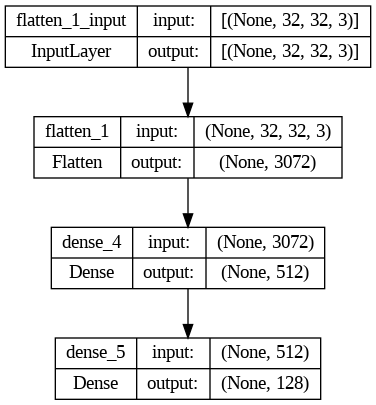

In [6]:
# Visualize the encoder
plot_model(vae.encoder, to_file='vae_encoder_plot.png', show_shapes=True, show_layer_names=True)

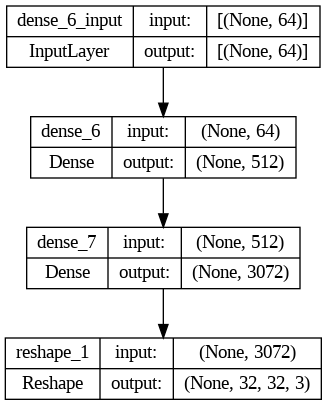

In [7]:
# Explicitly build the decoder model with the expected input shape
vae.decoder.build((None, vae.num_hidden))  # 'None' can be used for batch size flexibility

# Now you can plot the decoder model
plot_model(vae.decoder, to_file='vae_decoder_plot.png', show_shapes=True, show_layer_names=True)

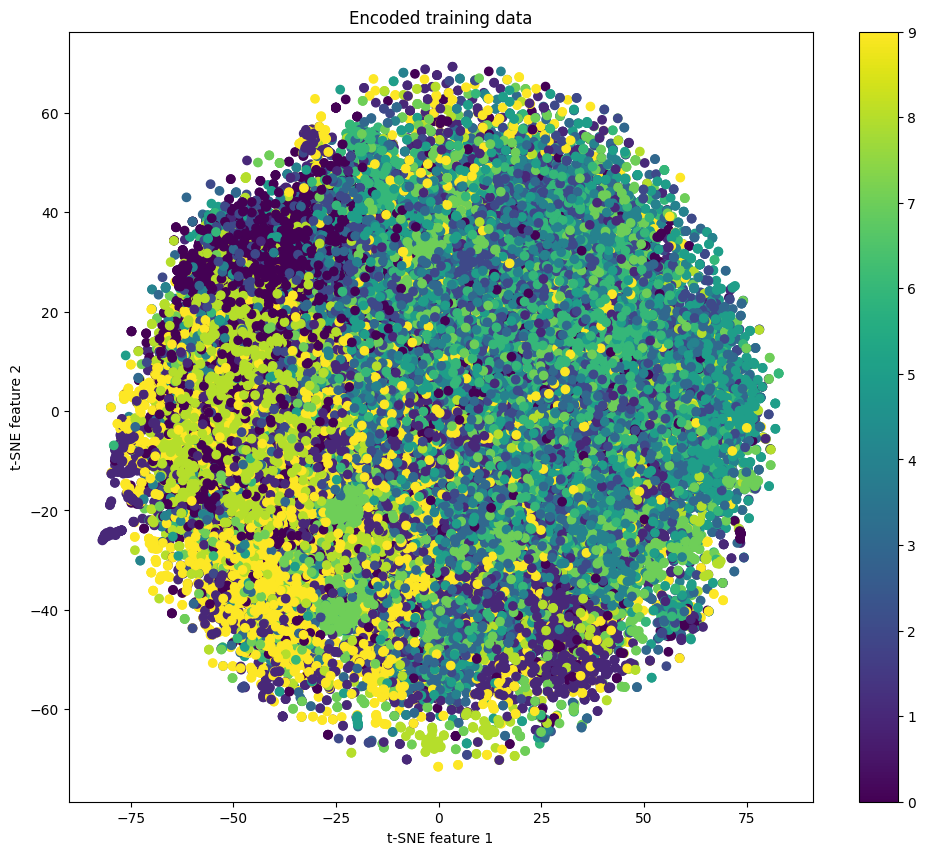

In [8]:
# Get the encoded representations
# No need to reshape since CIFAR-10 images are already 32x32x3
mean, _ = vae.encode(X_train)

# Use t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(mean.numpy())  # Convert to NumPy array if mean is a TensorFlow tensor

# Plotting the result of t-SNE
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_train.squeeze(), cmap='viridis')
plt.colorbar(scatter)
plt.title('Encoded training data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()
